# 2 - End to end machine learning project

In this chapter, we will work through an end-to-end machine
learning project to get the feel for the field. We will work
with real-estate data, pretending to work for a real-estate 
company.

In [31]:
import pandas as pd
import numpy as np

## Look at the Big Picture

Our first task will be to create a model to find the median
house price for each district in the data.

### Framing the problem

First, we need to understand what is the objective of building
this model. We ask our boss, and he answers that this model
will be used to decide whether or not it is worth it to invest
in a given area. Moreover, our model results will be fed to 
another ML system to make this decision, so it is important
our results are as accurate as possible.

The next question is **what are the current solutions** to this
objective. This will help us find a metric for our performance,
as well as put our solution in perspective. Our boss answers
that currently there is a team of experts that do this estimation,
and that sometimes their estimates are off by up to 30%.

Let's begin designing our system by answering some questions.
The most basic one - what type of system is ours? Supervised,
for a regression task, I believe. As for batch or online learning,
batch will suffice, as housing sells are usually a slow process,
and accuracy is key in this context.

The authors says this is, more specifically a **multiple regression**
problem, and an **univariate** one, because we are using multiple 
features to predict a single variable.

### Select a Performance Measure

A typical regression measure for regression problems is the 
root mean squared error (RMSE), in which for each instance, we
calculate the error, square this value, sum all square errors
and take the mean, and than root this value. This is more sensible
to high errors.

### Check the Assumptions

It is important to check if what we're assuming is actually right
about this system. For example, maybe the team that will use our
output data won't use the numeric data, but will categorize it 
in 'Cheap', 'Expensive', 'Medium', etc. In that case, our task 
would not be a regression task, but a classification one! We're 
better finding this out now, instead of months down the line.

In this case, after talking to the downstream team, they reassure
us that they'll need the numeric data.

## Get the Data

Time to get our hands dirty!

### Download the Data

We'll do that by code:

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path('datasets/housing.tgz')
  if not tarball_path.is_file():
    Path('datasets').mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path='datasets', filter='data')
  return pd.read_csv('datasets/housing/housing.csv')

housing_full = load_housing_data()

In [2]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing_full['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

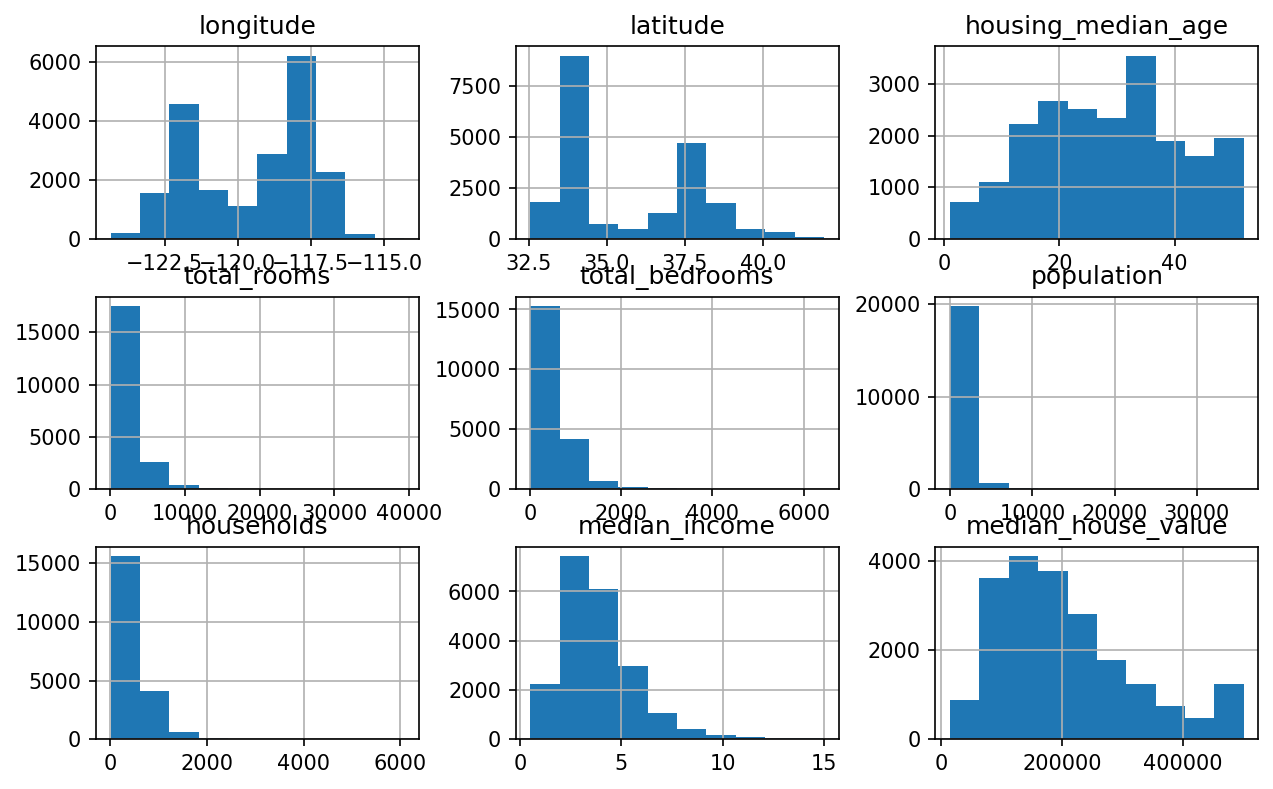

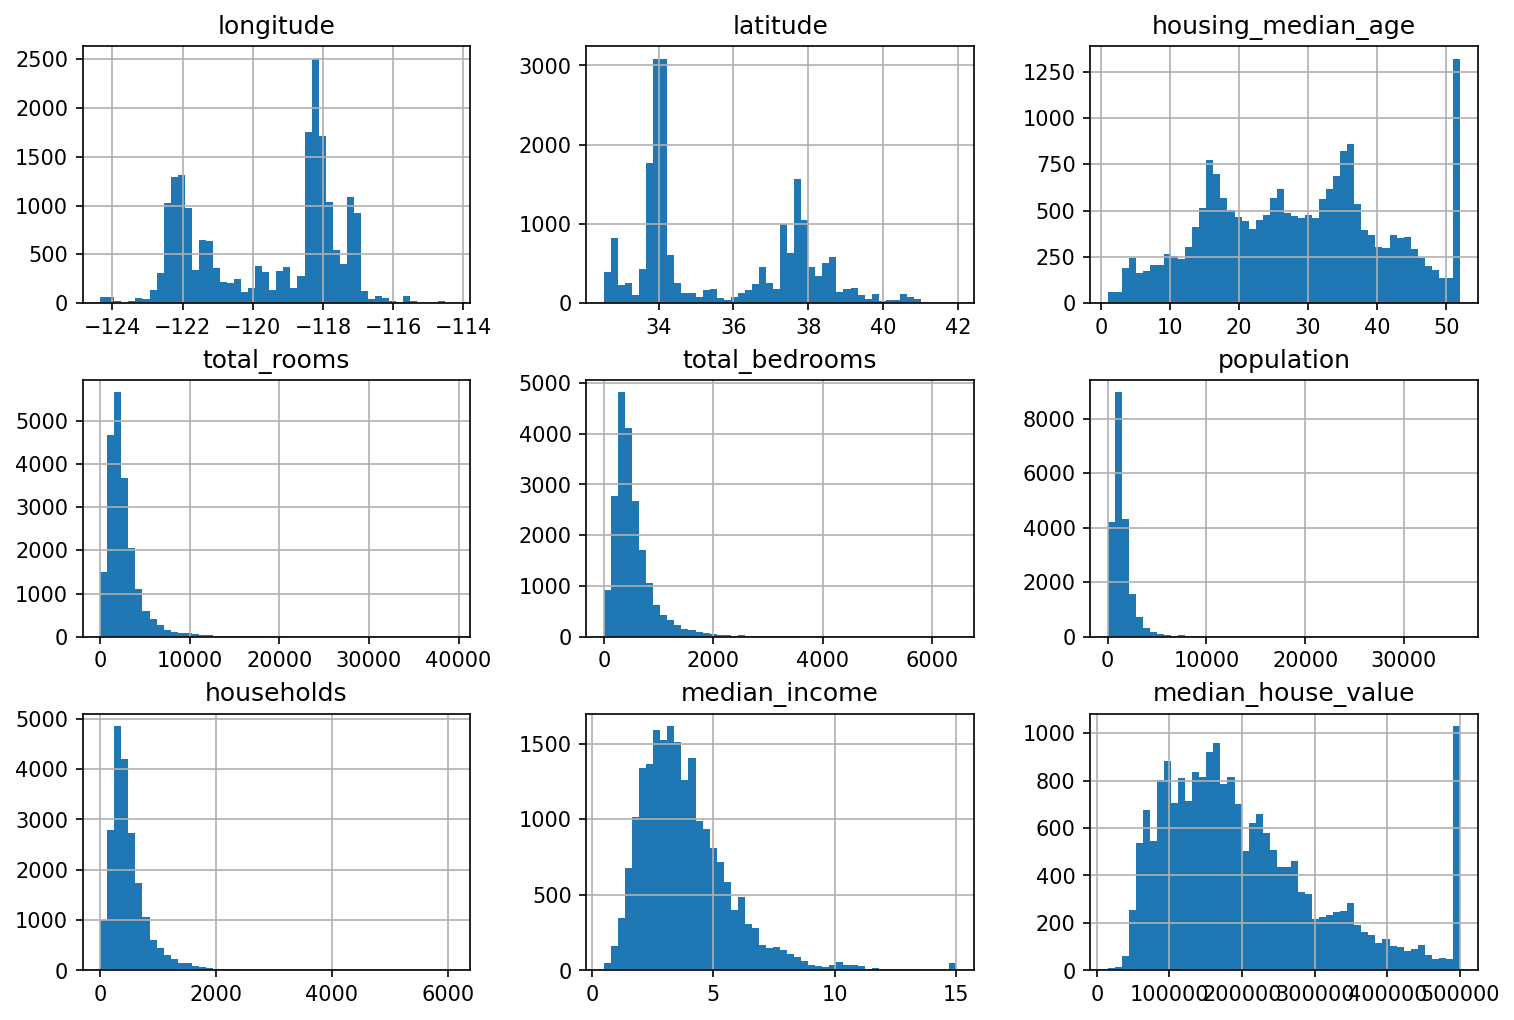

In [7]:
import matplotlib.pyplot as plt
housing_full.hist(bins=50, figsize=(12, 8))

We notice a few things:

- Median income is not expressed in USD. We talk to the
team that collected the data and discover the data has been
capped and scaled. The numbers roughly mean tens of thousands
of dollars.``

- House median value and age have also been capped, which 
might be a problem as median value is our target feature.
We might have to look for labels for these capped values or 
remove them entirely.

- The attributes are at very different scales;

- Many histograms are skewed right, which might need
some data transforming for the ML algorithms to properly
detect patterns

### Create a Test Set

We need to create a test set now, before cleaning 
the data and making decisions about which model to use.
This is because we might end up in the *data snooping bias*
situation. sklearn has a fuction for this, `train_test_split`:

In [29]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_full, test_size=0.2,
                                       random_state=42)

This would be a purely random sampling method. It is fine if
the data is large enough, but if it is not, we run at the risk
of introducing sampling bias. 

Suppose we talked to experts who told us *median_income* is an
important predictor for our target measure. If we wanted to make
sure that our data has representatives of each income category,
we might want to make an *stratified split*.
We notice most values of median income are between 1.5 and 6.
Thus, we can use `pd.cut()` to make categories for that:

In [33]:
housing_full['income_cat'] = pd.cut(housing_full['median_income'],
                                    bins=[0, 1.5, 3, 4.5, 6, np.inf],
                                    labels=[1, 2, 3, 4, 5])

<Axes: xlabel='income_cat'>

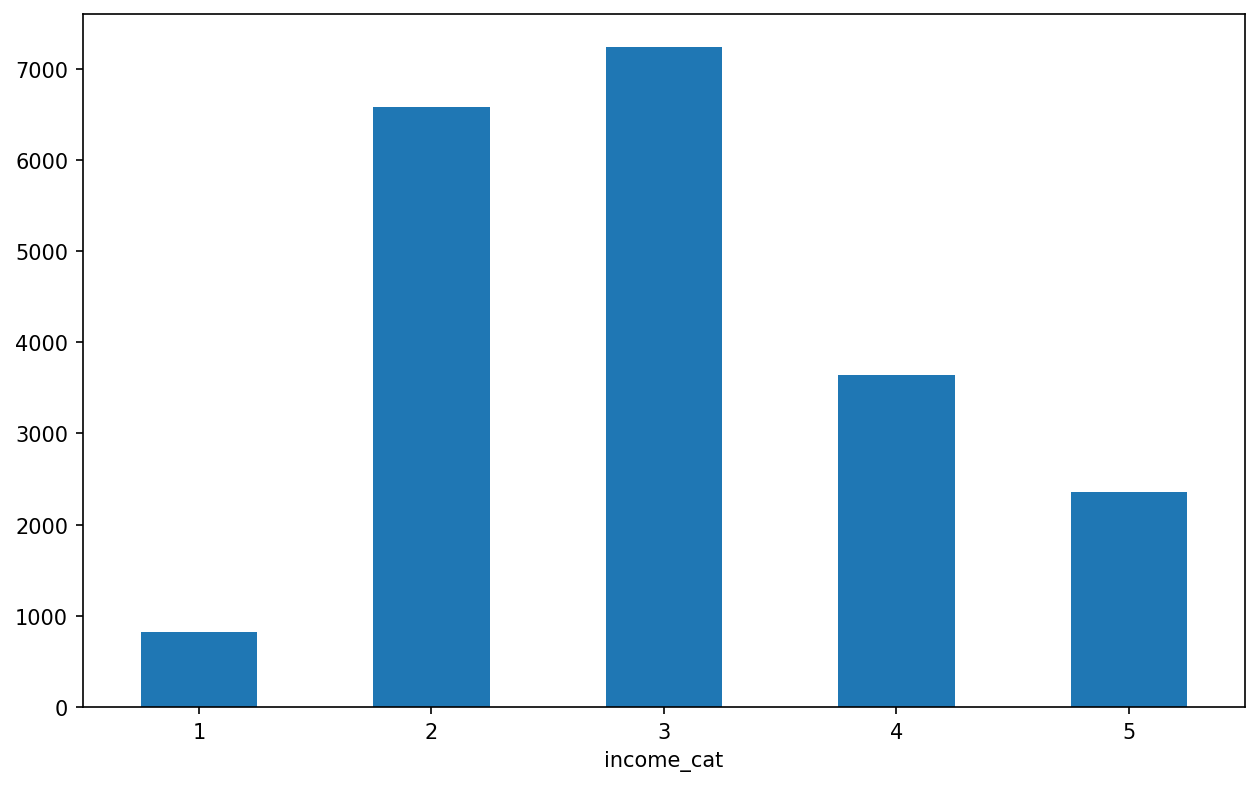

In [39]:
housing_full['income_cat'].value_counts().sort_index().plot.bar(rot=0)

Now we can use sklearn.model_selection's StratifiedShuffleSplit,
which returns a n lists of training and test indices. The n part
is good for later cross-validation. 

More precisely, StratifiedShuffleSplit has a `split()` method that
returns an iterator with the train and test indices.

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_splits = []
for train_idx, test_idx in splitter.split(housing_full,
                                          housing_full['income_cat']):
  train_set = housing_full.iloc[train_idx]
  test_set = housing_full.iloc[test_idx]
  strat_splits.append([train_set, test_set])

For now, we'll use the first split:

In [46]:
strat_train_set, strat_test_set = strat_splits[0]

There's a shorter way to do this, although it will
require looping for using 10 strats:

In [ ]:
strat_train_set, strat_test_set = train_test_split(
  housing_full, test_size=0.2, stratify=housing['income_cat'],
  random_state=42
)

Lets check if the income categories proportions are 
equal to those in the original dataset:

In [47]:
print(housing_full['income_cat'].value_counts(normalize=True))
print(strat_test_set['income_cat'].value_counts(normalize=True))

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: proportion, dtype: float64
income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: proportion, dtype: float64


Pretty accurate. Now that we won't use `income_cat`
again, we might as well just drop it:

In [ ]:
for train_set, test_set in strat_splits:
  train_set = train_set.drop('income_cat', axis=1)
  train_set = test_set.drop('income_cat', axis=1)

In [51]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


We took quite some time preparing this test set.
But it is our goal, what we will fir our model to 
excel at. It is a often neglected, but certainly important 
part of the machine learning process.